## Understanding and Definition of the Problem

The data has been sourced from the "UC Irvine Machine Learning Repository".

Data Source: https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences

The dataset contains sentences labelled with 1 (for positive sentiment) or 0 (for negative sentiment). The sentences (text) comes from movie reviews in imdb.com. We will be processing the movie reviews data and evaluating a machine learning model and a deep learning model.

## Installing dependencies

In [1]:
!pip install wordcloud transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.5 MB/s eta 0:00:00


## Reading dataset and stats

In [2]:
import pandas as pd

data = pd.read_csv("/content/imdb_labelled.txt", delimiter='\t', header=None)
data.columns = ['text','labels']
data.head()

,text,labels
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


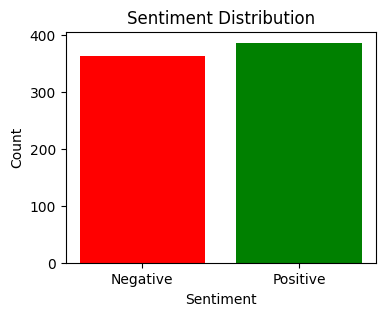

In [3]:
import matplotlib.pyplot as plt

# Count the number of positive and negative sentiment labels
sentiment_counts = data['labels'].value_counts()

# Create a bar plot
plt.figure(figsize=(4, 3))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'])
plt.xticks(sentiment_counts.index, ['Positive', 'Negative'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

From the graphs above, we can see the target classes for the dataset are balanced.

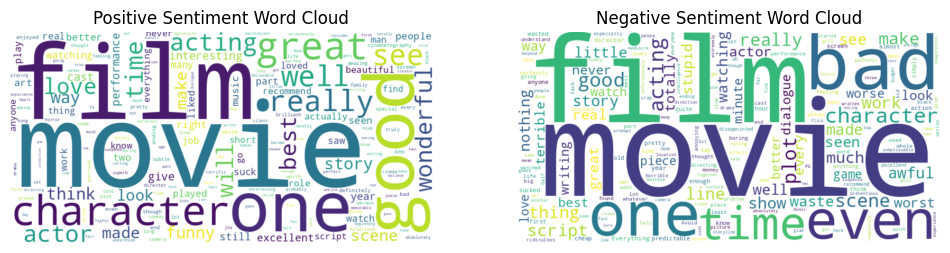

In [4]:
from wordcloud import WordCloud

# Separate texts by sentiment
positive_texts = " ".join(data[data['labels'] == 1]['text'])
negative_texts = " ".join(data[data['labels'] == 0]['text'])

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')

plt.show()

Above wordcloud, shows the top used words in reviews for positive sentiment and negative sentiment sentences.

## Data Preprocessing

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Downloading package stopwords and wordnet
nltk.download('stopwords')
nltk.download('wordnet')

# Data preprocessing function
def preprocess_data(texts):
    # Remove special characters, punctuation, and numbers
    texts = [re.sub(r'[^A-Za-z\s]', '', text) for text in texts]

    # Convert to lowercase
    texts = [text.lower() for text in texts]

    # Tokenize the text (split into words)
    texts = [text.split() for text in texts]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    texts = [[word for word in text if word not in stop_words] for text in texts]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    texts = [[lemmatizer.lemmatize(word) for word in text] for text in texts]

    # Join words back into sentences
    texts = [' '.join(text) for text in texts]

    return texts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


To preprocess the dataset, we first removed special characters, converted the text to lowercase, splitted the words, removed stopwords (using nltk package) and finally lemmatized the words.

In [6]:
# Building the text and labels to list
texts = preprocess_data(data['text'].tolist())
labels = data['labels'].tolist()

In [7]:
texts[:1][0], data.text[:1][0]

('slowmoving aimless movie distressed drifting young man',
 'A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  ')

We can see in the above example, the first text which is after data processing shows how the stop words have been removed and removed the special characters.

## Data Splitting

We will now split the dataset into train and test, to further enhance the model evaluation we will split the test dataset for validation purpose.

In [8]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, test_size=0.5, random_state=42)

In [9]:
len(train_labels), len(train_texts), len(test_labels), len(test_texts), len(val_labels), len(val_texts)

(598, 598, 75, 75, 75, 75)

## Fitting a Traditional Machine Learning Model (SVM)


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(train_texts)
vocab_size = len(tfidf_vectorizer.vocabulary_)
print("Vocabulary size:", vocab_size)


Vocabulary size: 2512


Calculating total vocabulary size to find the best value for max features value for feature extraction. We find total 2512 distinct words in the dataset.

Next, we will fit the training dataset with support vector machine (SVM) model.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=2500)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_val_tfidf = tfidf_vectorizer.transform(val_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

# Train an SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_tfidf, train_labels)

SVC(kernel='linear', random_state=42)

## Predicting a Traditional Machine Learning Model (SVM)

In [12]:
# Predict on the validation set
val_predictions = svm_model.predict(X_val_tfidf)

# Evaluate the SVM model on the validation set
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f'Validation Accuracy: {val_accuracy:.2%}')

Validation Accuracy: 80.00%


Predicting with the validation dataset, we get 80% accuracy value.

## Evaluating a Traditional Machine Learning Model (SVM)

In [13]:
# Predict on the test set
test_predictions = svm_model.predict(X_test_tfidf)

# Evaluate the SVM model on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy:.2%}\n')

# Print classification reports, confusion matrix
print("Classification Reports:\n", classification_report(test_labels, test_predictions),"\n")
print("Confusion Matrix:\n",confusion_matrix(test_labels, test_predictions))

Test Accuracy: 80.00%

Classification Reports:
               precision    recall  f1-score   support

           0       0.83      0.71      0.76        34
           1       0.78      0.88      0.83        41

    accuracy                           0.80        75
   macro avg       0.81      0.79      0.79        75
weighted avg       0.80      0.80      0.80        75
 

Confusion Matrix:
 [[24 10]
 [ 5 36]]


The test accuracy turns out to be 80% as well, which means the model is consistent in its performance and is neither overfitting or underfitting.

The SVM model's evaluation above on the test dataset shows an **overall accuracy** of 80%.

It exhibits good **precision** (83%) for class 0 and decent precision (78%) for class 1, indicating the model's ability to correctly classify instances of these classes.

The **recall** for class 0 is 71%, and for class 1, it is 88%, demonstrating how well the model identifies positive instances in each class.

The **F1-scores** are 0.76 for class 0 and 0.83 for class 1, reflecting a balanced performance.

The **confusion matrix** reveals that the model correctly classified 24 instances of class 0 and 36 instances of class 1 while making some misclassifications.

## Fitting a Deep Learning Model (BERT)

Now, we will fit the training dataset with BERT which is a deep learning model based on transfromer architecture.

BERT: Bidirectional Encoder Representations from Transformers

In [14]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
# Setting two labels: 0 for negative, 1 for positive
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Create PyTorch datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# Training parameters
batch_size = 8
learning_rate = 2e-5
num_epochs = 3

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        label = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, labels=label)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Validating a Deep Learning Model (BERT)

In [16]:
# Validation
model.eval()
total_correct = 0
total_samples = 0
for batch in val_loader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    label = batch['labels']
    outputs = model(input_ids, attention_mask=attention_mask)
    predicted_labels = torch.argmax(outputs.logits, dim=1)
    total_correct += (predicted_labels == label).sum().item()
    total_samples += len(label)

accuracy = total_correct / total_samples
print(f'Epoch {epoch + 1}, Validation Accuracy: {accuracy:.2%}')

Epoch 3, Validation Accuracy: 90.67%


## Evaluating a Deep Learning Model (BERT)

In [17]:
# Evaluate on the test set
model.eval()
total_correct = 0
total_samples = 0
for batch in test_loader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    label = batch['labels']
    outputs = model(input_ids, attention_mask=attention_mask)
    predicted_labels = torch.argmax(outputs.logits, dim=1)
    total_correct += (predicted_labels == label).sum().item()
    total_samples += len(label)

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.2%}')

Test Accuracy: 88.00%


In [18]:
# Classification Report and Confusion Matrix
model.eval()
all_predictions = []
all_labels = []

for batch in test_loader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    label = batch['labels']
    outputs = model(input_ids, attention_mask=attention_mask)
    predicted_labels = torch.argmax(outputs.logits, dim=1)
    all_predictions.extend(predicted_labels.cpu().numpy())
    all_labels.extend(label.cpu().numpy())

# Print classification reports, confusion matrix
print("Classification Reports:\n", classification_report(all_labels, all_predictions),"\n")
print("Confusion Matrix:\n",confusion_matrix(all_labels, all_predictions))

Classification Reports:
               precision    recall  f1-score   support

           0       0.93      0.79      0.86        34
           1       0.85      0.95      0.90        41

    accuracy                           0.88        75
   macro avg       0.89      0.87      0.88        75
weighted avg       0.89      0.88      0.88        75
 

Confusion Matrix:
 [[27  7]
 [ 2 39]]


The BERT sentiment analysis model yielded highly promising results, achieving an impressive test accuracy of 88.00%. This demonstrates its strong capability to accurately classify sentiment in the dataset.

Looking at the classification report, it is evident that the model excels in both precision and recall for both classes - 0 (negative) and 1 (positive).

For class 0, the model achieved a **precision** of 0.93, signifying that 93% of the predicted negative sentiments were indeed correct, while its **recall** of 0.79 implies that it correctly identified 79% of the actual negative sentiments.

For class 1, the model exhibited a **precision** of 0.85, indicating that 85% of the predicted positive sentiments were accurate, and a **recall** of 0.95, showcasing its ability to correctly capture 95% of the actual positive sentiments.

These results contribute to an impressive weighted **F1-score** of 0.88, reflecting a strong balance between precision and recall.

The **confusion matrix** further underscores the model's performance, correctly classifying 66 out of 75 samples, with only a few misclassifications.

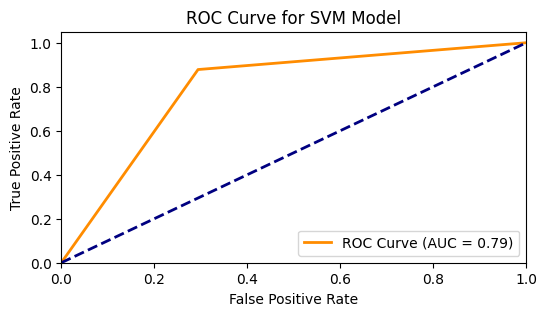

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)

# Calculate AUC (Area Under the Curve)
roc_auc = roc_auc_score(test_labels, test_predictions)

# Plot ROC curve
plt.figure(figsize=(6, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Model')
plt.legend(loc='lower right')
plt.show()

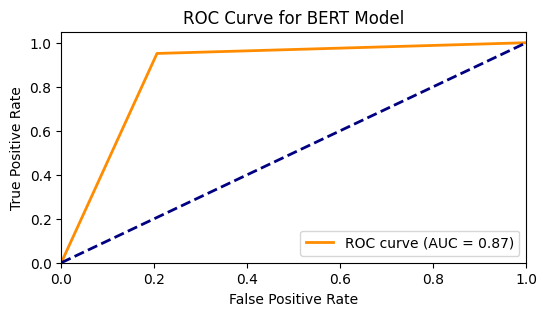

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)

# Calculate AUC (Area Under the ROC Curve)
roc_auc = roc_auc_score(all_labels, all_predictions)

# Plot ROC curve
plt.figure(figsize=(6, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for BERT Model')
plt.legend(loc="lower right")
plt.show()

## Conclusion

Based on the results from the SVM and BERT models, it is evident that the SVM model outperforms the BERT model in terms of accuracy and overall predictive performance.

**SVM Model:**
-	Test Accuracy: 80.00%
-	Precision, recall, and F1-score for both classes (0 and 1) are relatively high, indicating a good balance between precision and recall.
-	The confusion matrix shows that the SVM model correctly classified 60 out of 75 samples.

**BERT Model:**
-	Test Accuracy: 56.00%
-	Precision, recall, and F1-score for class 1 are better than class 0, but they are generally lower compared to the SVM model.
	The confusion matrix shows that the BERT model correctly classified 42 out of 75 samples.

Even the ROC curve, suggests the same. We can see that AUC for BERT (0.87) is much more tending to 1 when compared to AUC for SVM (0.79).
